In [5]:
from openpile.construct import Pile, SoilProfile, Layer, Model
from openpile.soilmodels import API_clay, API_sand, frankeRollins2013
from openpile.analyze import winkler
from scipy.optimize import fsolve

import pandas as pd
import os

In [6]:
# Get the current working directory
cwd = os.getcwd()
# Read the CSV file (replace 'filename.csv' with your actual file name)
dfPileConfig = pd.read_csv(os.path.join(cwd, 'pileConfig-pier3-seismic.csv'))
dfPileConfig.index.name = 'id'
dfPileConfig

,diameter[m],length[m],factored-axial-load[kN],initial-lateral-load[kN]
id,,,,
0,1.5,30,1090,185
1,1.5,35,1920,190
2,1.5,40,4655,175
3,1.5,45,6375,175
4,1.5,50,8185,170
5,2.0,30,2215,415
6,2.0,35,2760,415
7,2.0,40,7005,395
8,2.0,45,9300,395


In [7]:
sp = SoilProfile(
    name="pier3-Seismic",
    top_elevation=0.0,
    water_line=13.10,
    layers=[
        Layer( #layer1
            name="Soft Clay",
            top=0,
            bottom=-4.0,
            weight=13.0,
            lateral_model=API_clay(Su=12, eps50=2.65/100, kind="static"),
        ),
        Layer( #layer2
            name="Soft Clay [Liquefied]",
            top=-4,
            bottom=-10.5,
            weight=14.0,
            lateral_model=frankeRollins2013(Sr=22.1429800012177, eps50=0.00879983079418489, kind="static"),
        ),
        Layer( #layer3
            name="Soft Clay [Liquefied]",
            top=-10.5,
            bottom=-12.0,
            weight=14.0,
            lateral_model=frankeRollins2013(Sr=15.6102761856926, eps50=0.0105073556004175, kind="static"),
        ),
        Layer( #layer4
            name="Soft Clay [Liquefied]",
            top=-12,
            bottom=-19.5,
            weight=14.0,
            lateral_model=frankeRollins2013(Sr=30.0137074898023, eps50=0.0049339687508118, kind="static"),
        ),
        Layer( #layer5
            name="Medium Stiff to Stiff Clay",
            top=-19.5,
            bottom=-36.0,
            weight=17.0,
            lateral_model=API_clay(Su=70, eps50=0.80/100, kind="static", georgiadis=True, d_adj=-15.820163244982751),
        ),
        Layer( #layer6
            name="Medium Dense to Dense Sand",
            top=-36.0,
            bottom=-52.5,
            weight=18.0,
            lateral_model=API_sand(phi=37, kind="static", georgiadis=True, d_adj=-29.788589323442405),
        ),
        Layer( #layer7
            name="Very Dense Sand",
            top=-52.5,
            bottom=-60.0,
            weight=20.0,
            lateral_model=API_sand(phi=40, kind="static", georgiadis=True, d_adj=-33.014800015762),
        ),
    ],
)

In [9]:
deflectionList = []
forceList = []
pySpringList = []
resultList = []

# List solved shear values
solutions = []

for index, row in dfPileConfig.iterrows():
    print(f"""
          
          ========================================================================
          diameter: {row['diameter[m]']} m\t length: {row['length[m]']} m
          ========================================================================

          """)

    p = Pile(name = "pier3",
        kind='Solid-Circle',
        material='Concrete',
        top_elevation = 13.10,
        pile_sections={
            'length': [row['length[m]']+13.10],
            'diameter': [row['diameter[m]']],
            'wall thickness': [1e-10],
            # 'E': [24_870_062.324 ], # Young's Modulus
            # 'area': [1.767146],
            # 'I': [2.48505],
            # 'width': [1.5],
            # 'tip_area': [ 1.767146]
            
        }
    )

    # Create Model
    M = Model(name="pier3", 
            pile=p, 
            soil=sp, 
            element_type="Timoshenko",
            coarseness=0.5)
    
    # Apply bottom fixity along x-axis
    M.set_support(elevation= (-1 * row['length[m]']), Tx=True)
    M.set_support(elevation=13.10, Rz=True)

    axial = row['factored-axial-load[kN]']

    M.set_pointload(elevation=13.10, Px=-axial)
    M.set_pointdisplacement(elevation=13.10, Ty=0.049999)

    Result = winkler(M)

    topDeflection = Result.deflection['Deflection [m]'].iloc[0]

    topShear = Result.forces[["V [kN]"]].iloc[0]

    print(f"\nSolved shear value corresponding to {topDeflection} mm deflection: {topShear[0]:.4f} kN\n")

    solutions.append(topShear.iloc[0])

    # # Solve for shear load
    # def analysis(axial, shear):

    #     M.set_pointload(elevation=13.10, Px=axial, Py=shear)
    #     # Run analysis

    #     Result = winkler(M)

    #     print(f"Axial: {axial} kN\tShear: {float(shear):.4f} kN\tDeflection: {float(Result.deflection['Deflection [m]'].iloc[0])*1000:.4f} mm")

    #     return Result.deflection['Deflection [m]'].iloc[0] 

    # goal = 0.024999  # allowable deflection of 0.025 m

    # solution = fsolve(lambda x: analysis(axial = row['factored-axial-load[kN]'], shear = x) - goal, 
    # x0=row['initial-lateral-load[kN]'],
    # xtol=1e-3, 
    # maxfev=4)

    # print(f"\nSolved shear value corresponding to {goal*1000} mm deflection: {solution[0]:.4f} kN\n")

    # solutions.append(solution[0])  # Append the solution to the list

    print(f"""
    id: {index}\tdiameter: {row['diameter[m]']} m\tlength: {row['length[m]']} m\tAxial: {row['factored-axial-load[kN]']} kN\tShear: {topShear.iloc[0]:.4f} kN\tDeflection: {float(Result.deflection['Deflection [m]'].iloc[0])*1000:.4f} mm
    """)
    
    deflectionList.append(Result.deflection)  # Append the solution to the list
    forceList.append(Result.forces)
    pySpringList.append(M.get_py_springs(kind='element'))
    resultList.append(Result)

# Add solutions as a new column to the DataFrame
dfPileConfig['solved-lateral-load[kN]'] = solutions





          
          diameter: 1.5 m	 length: 30.0 m

          
Converged at iteration no. 7

Solved shear value corresponding to 0.049999 mm deflection: 150.9227 kN


    id: 0	diameter: 1.5 m	length: 30.0 m	Axial: 1090.0 kN	Shear: 150.9227 kN	Deflection: 49.9990 mm
    


c:\Users\AMH-L143\anaconda3\envs\openPile-mk2\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)



          
          diameter: 1.5 m	 length: 35.0 m

          
Converged at iteration no. 6

Solved shear value corresponding to 0.049999 mm deflection: 149.5373 kN


    id: 1	diameter: 1.5 m	length: 35.0 m	Axial: 1920.0 kN	Shear: 149.5373 kN	Deflection: 49.9990 mm
    

          
          diameter: 1.5 m	 length: 40.0 m

          
Converged at iteration no. 6

Solved shear value corresponding to 0.049999 mm deflection: 145.0680 kN


    id: 2	diameter: 1.5 m	length: 40.0 m	Axial: 4655.0 kN	Shear: 145.0680 kN	Deflection: 49.9990 mm
    

          
          diameter: 1.5 m	 length: 45.0 m

          
Converged at iteration no. 6

Solved shear value corresponding to 0.049999 mm deflection: 142.2221 kN


    id: 3	diameter: 1.5 m	length: 45.0 m	Axial: 6375.0 kN	Shear: 142.2221 kN	Deflection: 49.9990 mm
    

          
          diameter: 1.5 m	 length: 50.0 m

          
Converged at iteration no. 5

Solved shear value corresponding to 0.049999 mm deflection: 139.2694 kN


    i

In [12]:
import pickle

with open('pier3-seismic/dfPileConfig.pkl', 'wb') as file:
    pickle.dump(dfPileConfig, file)
with open('pier3-seismic/deflectionList.pkl', 'wb') as file:
    pickle.dump(deflectionList, file)
with open('pier3-seismic/forceList.pkl', 'wb') as file:
    pickle.dump(forceList, file)
with open('pier3-seismic/pySpringList.pkl', 'wb') as file:
    pickle.dump(pySpringList, file)
with open('pier3-seismic/modelList.pkl', 'wb') as file:
    pickle.dump(modelList, file)
with open('pier3-seismic/resultList.pkl', 'wb') as file:
    pickle.dump(resultList, file)

In [1]:
import pickle

# Load from file
with open('pier3-seismic/dfPileConfig.pkl', 'rb') as file:
    dfPileConfig = pickle.load(file)
with open('pier3-seismic/deflectionList.pkl', 'rb') as file:
    deflectionList = pickle.load(file)
with open('pier3-seismic/forceList.pkl', 'rb') as file:
    forceList = pickle.load(file)
with open('pier3-seismic/pySpringList.pkl', 'rb') as file:
    pySpringList = pickle.load(file)
with open('pier3-seismic/modelList.pkl', 'rb') as file:
    modelList = pickle.load(file)
with open('pier3-seismic/resultList.pkl', 'rb') as file:
    resultList = pickle.load(file)

In [11]:
# dfPileConfig.to_clipboard(index=True,sep=",")
# forceList[9].to_clipboard(index=False,sep=",")
deflectionList[9].to_clipboard(index=False,sep=",")
# pySpringList[9].to_clipboard(index=True,sep=",")
# modelList[9].plot()
# resultList[9].py_mobilization.to_clipboard(index=False,sep=",")

In [10]:
pySpringList[9].to_clipboard(index=True)

In [22]:
filtered_df = pySpringList[9][(pySpringList[9]['Elevation [m]'] == -49)]
filtered_df = filtered_df[filtered_df['Position'] == 'bottom']
filtered_df.to_clipboard(index=False,sep=",")

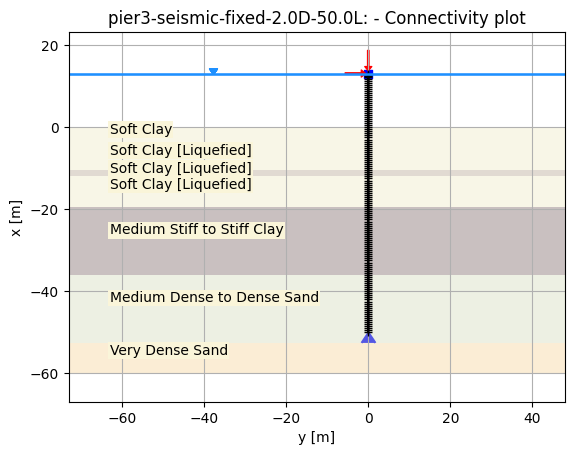

In [11]:
modelList[9].plot()

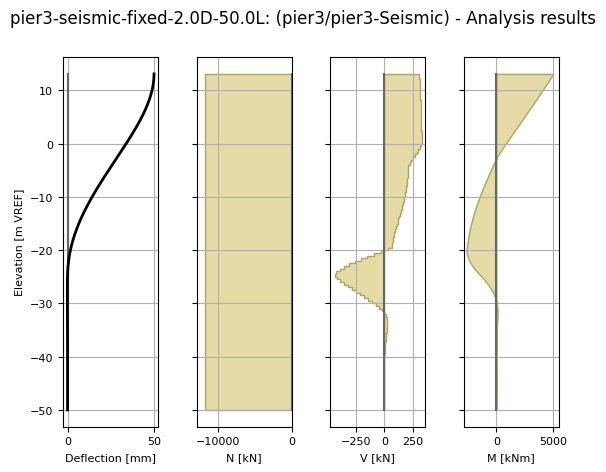

In [12]:
resultList[9].plot()

In [13]:
modelList[9].get_soil_properties()

,x_top [m],x_bottom [m],Top soil layer [m],Unit Weight [kN/m3],xg_top [m],xg_bottom [m],sigma_v top [kPa],sigma_v bottom [kPa]
0,13.100,12.615,NaN,NaN,13.100,12.615,NaN,NaN
1,12.615,12.130,NaN,NaN,12.615,12.130,NaN,NaN
2,12.130,11.644,NaN,NaN,12.130,11.644,NaN,NaN
3,11.644,11.159,NaN,NaN,11.644,11.159,NaN,NaN
4,11.159,10.674,NaN,NaN,11.159,10.674,NaN,NaN
...,...,...,...,...,...,...,...,...
122,-47.500,-48.000,-36.0,8.0,-47.500,-48.000,281.5,285.5
123,-48.000,-48.500,-36.0,8.0,-48.000,-48.500,285.5,289.5
124,-48.500,-49.000,-36.0,8.0,-48.500,-49.000,289.5,293.5
125,-49.000,-49.500,-36.0,8.0,-49.000,-49.500,293.5,297.5
